# Final Project

### 獲取歷史資料

In [2]:
from finlab.data import Data

data = Data()

rev = data.get("當月營收")
close = data.get("收盤價")

rev.index = rev.index.shift(5, "d") #營收公佈日10號後的5天，15號

D:\ProgramData\Miniconda3\envs\finlab\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### 計算features

In [3]:
def bias(n):
    return close / close.rolling(n, min_periods=1).mean()

def acc(n):
    return close.shift(n) / (close.shift(2*n) + close) * 2

def rsv(n):
    l = close.rolling(n, min_periods=1).min()
    h = close.rolling(n, min_periods=1).max()
    
    return (close - l) / (h - l)

def mom(n):
    return (rev / rev.shift(1)).shift(n)

features = {
    'mom1': mom(1),
    'mom2': mom(2),
    'mom3': mom(3),
    'mom4': mom(4),
    'mom5': mom(5),
    'mom6': mom(6),
    'mom7': mom(7),
    'mom8': mom(8),
    'mom9': mom(9),
    
    'bias5': bias(5),
    'bias10': bias(10),
    'bias20': bias(20),
    'bias60': bias(60),
    'bias120': bias(120),
    'bias240': bias(240),
    
    'acc5': acc(5),
    'acc10': acc(10),
    'acc20': acc(20),
    'acc60': acc(60),
    'acc120': acc(120),
    'acc240': acc(240),
    
    'rsv5': rsv(5),
    'rsv10': rsv(10),
    'rsv20': rsv(20),
    'rsv60': rsv(60),
    'rsv120': rsv(120),
    'rsv240': rsv(240),
}


### 製作dataset

##### 設定買賣頻率

In [4]:
every_month = rev.index
every_month

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2022-01-15', '2022-02-15', '2022-03-15', '2022-04-15',
               '2022-05-15', '2022-06-15', '2022-07-15', '2022-08-15',
               '2022-09-15', '2022-10-15'],
              dtype='datetime64[ns]', name='date', length=213, freq=None)

##### 將dataframe 組裝起來

In [5]:
# features['bias20'].reindex(every_month, method='ffill')

for name, f in features.items():
    features[name] = f.reindex(every_month, method='ffill')

In [6]:

for name, f in features.items():
    features[name] = f.unstack()

In [7]:
import pandas as pd
dataset = pd.DataFrame(features)

In [8]:
feature_names = list(dataset.columns)

### 新增 label

In [9]:
from finlab import ml

ml.add_profit_prediction(dataset)
ml.add_rank_prediction(dataset)

### 刪除太大太小的歷史資料

In [10]:
print(dataset.shape)

def drop_extreme_case(dataset, feature_names, thresh=0.01):
    
    extreme_cases = pd.Series(False, index=dataset.index)
    for f in feature_names:
        tf = dataset[f]
        extreme_cases = extreme_cases | (tf < tf.quantile(thresh)) | (tf > tf.quantile(1-thresh))
    dataset = dataset[~extreme_cases]
    return dataset

dataset_drop_extreme_case = drop_extreme_case(dataset, 
    ['bias60', 'bias120', 'bias240', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'mom6'], thresh=0.01)

print(dataset_drop_extreme_case.shape)

(433881, 29)
(405988, 29)


In [11]:
dataset_dropna = dataset_drop_extreme_case.dropna(how='any')
dataset_dropna = dataset_dropna.reset_index().set_index("date")

In [12]:
dataset_drop_extreme_case.index.get_level_values("date")

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2022-01-15', '2022-02-15', '2022-03-15', '2022-04-15',
               '2022-05-15', '2022-06-15', '2022-07-15', '2022-08-15',
               '2022-09-15', '2022-10-15'],
              dtype='datetime64[ns]', name='date', length=405988, freq=None)

In [13]:
##############################################　　　自己加入的　　　##############################################

dataset_dropna.index = pd.to_datetime(dataset_dropna.index)
dataset_dropna = dataset_dropna.sort_index()

#修復＜class ‘numpy.ndarray‘＞　https://blog.csdn.net/lxbin/article/details/114005757

In [14]:
dataset_train = dataset_dropna[:'2015']
dataset_test = dataset_dropna['2016':]

### 神經網路模型

In [15]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers

import os


os.environ['KMP_DUPLICATE_LIB_OK']='True'

model = keras.models.Sequential()
model.add(layers.Dense(100, activation='relu',
                      input_shape=(len(feature_names),),
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dense(100, activation='relu',
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(1, activation='sigmoid'))


model.summary()

model.compile(loss='mean_squared_error',
              optimizer="adam",)

print('start fitting')
history = model.fit(dataset_train[feature_names], dataset_train['rank'],
                    batch_size=1000,
                    epochs=225,
                    verbose=1,
                    validation_split=0.1, )


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2800      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 13,001
Trainable params: 13,001
Non-trainable params: 0
_________________________________________________________________
start fitting
Epoch 1/225
80/80 [==============================] - ETA: 0s - loss: 0.171 - ETA: 0s - loss: 0.151 - ETA: 0s - loss: 0.123 - ETA: 0s - loss: 0.108 - ETA: 0s - loss: 0.102 - ETA: 0s - loss: 0.100 - ETA: 0s - loss: 0.099 - ETA: 0s - los

In [16]:
!pip show protoc 

### 結果

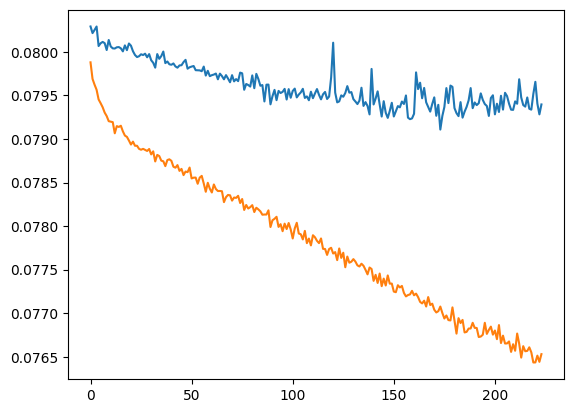

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['val_loss'][1:])
plt.plot(history.history['loss'][1:])

### lightgbm Model

In [18]:
import lightgbm as lgb
cf = lgb.LGBMRegressor(n_estimators=500)
cf.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

LGBMRegressor(n_estimators=500)

### Random Forest Model

In [19]:
from sklearn.ensemble import RandomForestRegressor

cf2 = RandomForestRegressor(n_estimators=100)
cf2.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

RandomForestRegressor()

<AxesSubplot:xlabel='Value', ylabel='Feature'>

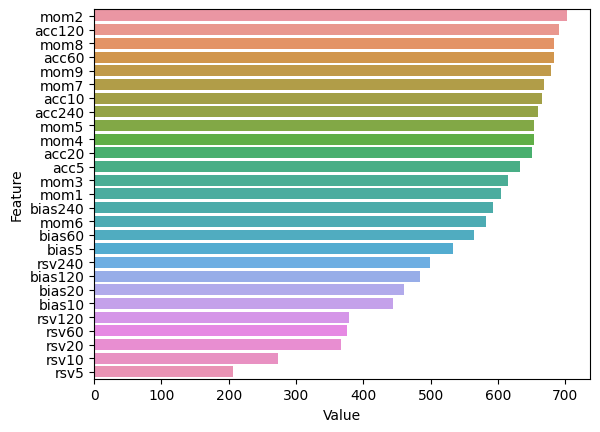

In [20]:
feature_imp = pd.DataFrame(zip(cf.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
sns.barplot(x="Value", y="Feature", data=feature_imp)

### Ensemble learning

In [21]:
dataset_drop = dataset.dropna(subset=feature_names+['return'])

vals = model.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result1'] = pd.Series(vals.swapaxes(0,1)[0], dataset_drop.index)

vals = cf.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result2'] = pd.Series(vals, dataset_drop.index)

vals = cf2.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result3'] = pd.Series(vals, dataset_drop.index)

dataset_drop = dataset_drop.reset_index().set_index("date")

D:\ProgramData\Miniconda3\envs\finlab\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\ProgramData\Miniconda3\envs\finlab\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
D:\ProgramData\Miniconda3\envs\finlab\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

# backtest

<AxesSubplot:xlabel='date'>

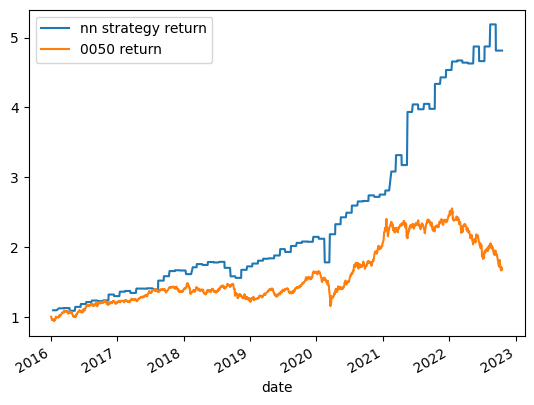

In [22]:
import math


dates = sorted(list(set(dataset_drop.index)))

rs = []
for d in dates:
    
    dataset_time = dataset_drop.loc[d]
    
    dataset_time = drop_extreme_case(dataset_time, 
        ['bias60', 'bias120', 'bias240', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'mom6'], thresh=0.01)
    
    rank = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3'] 
    
    condition = (rank >= rank.nlargest(20).iloc[-1]) 
    r = dataset_time['return'][condition].mean()

    rs.append(r * (1-3/1000-1.425/1000*2*0.6))

rs = pd.Series(rs, index=dates)['2016':].cumprod()

s0050 = close['0050']['2016':]

pd.DataFrame({'nn strategy return':rs.reindex(s0050.index, method='ffill'), '0050 return':s0050/s0050[0]}).plot()



### 當月持股狀況

In [23]:
dataset.index.levels[1]

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2022-01-15', '2022-02-15', '2022-03-15', '2022-04-15',
               '2022-05-15', '2022-06-15', '2022-07-15', '2022-08-15',
               '2022-09-15', '2022-10-15'],
              dtype='datetime64[ns]', name='date', length=213, freq=None)

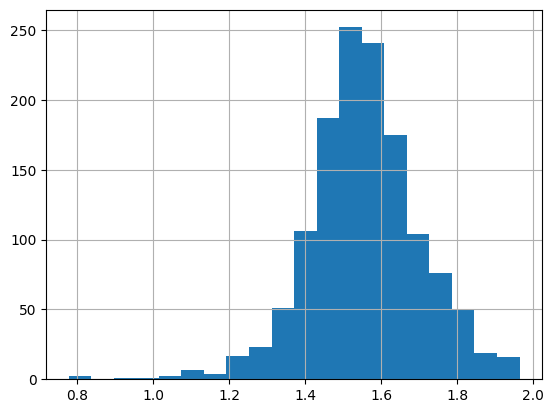

In [24]:
# get the latest dataset
last_date = "2019-07-15"#dataset.index.levels[1].max()
is_last_date = dataset.index.get_level_values('date') == last_date
last_dataset = dataset[is_last_date].copy()


last_dataset = drop_extreme_case(last_dataset, 
    ['bias60', 'bias120', 'bias240', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'mom6'], thresh=0.01)


# remove NaN testcases
last_dataset = last_dataset.dropna(subset=feature_names)

# predict

vals = model.predict(last_dataset[feature_names].astype(float))
last_dataset['result1'] = pd.Series(vals.swapaxes(0,1)[0], last_dataset.index)

vals = cf.predict(last_dataset[feature_names].astype(float))
last_dataset['result2'] = pd.Series(vals, last_dataset.index)

vals = cf2.predict(last_dataset[feature_names].astype(float))
last_dataset['result3'] = pd.Series(vals, last_dataset.index)

# calculate score

rank = last_dataset['result1'] + last_dataset['result2'] + last_dataset['result3']
condition = (rank >= rank.nlargest(20).iloc[-1]) 

# plot rank distribution
rank.hist(bins=20)


# show the best 20 stocks
slist1 = rank[condition].reset_index()['stock_id']

# 平均分配資產於股票之中

In [25]:
close = data.get("收盤價")

money = 1000000
stock_prices = close[rank[condition].reset_index()['stock_id']].iloc[-1]


print("股票平分張數:")
money / len(stock_prices) / stock_prices / 1000


股票平分張數:


stock_id
1103    3.076923
1216    0.765697
1752    1.501502
2511    4.694836
2801    3.058104
2836    4.149378
2849    3.584229
2892    2.105263
3528    1.013171
3531    1.818182
4205    0.497512
5403    0.786164
5530    1.362398
5871    0.290698
6201    1.288660
8032    1.709402
8249    2.352941
9908    1.672241
9917    0.526316
9925    1.293661
Name: 2022-10-19 00:00:00, dtype: float64